# 네이버 영화 리뷰 감성분석 도전하기

# 목차

1. 라이브러리
2. 데이터 준비 및 확인
    - 데이터의 중복 제거
    - NaN 결측치 제거
    - 한국어외 모두 제거
    - 한국어 토크나이저로 토큰화
    - 불용어 제거
    - 사전 word_to_index 구성
    - 텍스트 스티링을 사전 인덱스 스트링으로 변환
    - X_train, y_train, X_test, y_test, word_to_index 리턴
3. 모델 구성을 위한 데이터 분석 및 가공
    - 데이터셋 내 문장 길이 분포
    - 적절한 최대 문장 길이 지정
    - keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가
    - validation set 구성
4. 모델 구성 및 학습 및 시각화
    - 모델 1
    - 모델 2
    - 모델 3
5. 학습된 Embedding 레이어 분석
    - 함수화
    - 레이어 분석
6. 한국어 Word2Vec 임베딩 활용하여 성능 개선

# 루브릭 평가기준

| 평가문항  | 상세기준   |
| :------------ | :------------ |
|  1. 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다. |  3가지 이상의 모델이 성공적으로 시도됨 |
|  2. gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다. | gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 적절히 분석함  |
|  3. 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다. |  네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함 |

# 1. 라이브러리

In [21]:
import re
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import gensim
from konlpy.tag import Mecab
from collections import Counter
from tensorflow.keras.initializers import Constant
from gensim.models.keyedvectors import Word2VecKeyedVectors


# 2. 데이터 준비 및 확인

In [22]:
# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [23]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
hangul = re.compile('[^ 가-힣+]')
def load_data(train_data, test_data, num_words=10000):
    # 중복제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    # 결측치 제거
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any')
    
    X_train = []
    for sentence in train_data['document']:
        # 한글외 모두 삭제
        new_setence = hangul.sub('', sentence)
        temp_X = tokenizer.morphs(new_setence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)
        
    
    X_test = []
    for sentence in test_data['document']:
        new_setence = hangul.sub('', sentence)
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
        
    # 사전 word_to_index 구성
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
      
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    # 텍스트 스티링을 사전 인덱스 스트링으로 변환
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
x_train, y_train, x_test, y_test, word_to_index = load_data(train_data, test_data)

In [24]:
len(x_train), len(y_train), len(x_test), len(y_test)

(146182, 146182, 49157, 49157)

## 한국어외 모두 제거하여 빈 리스트 존재하여 삭제

In [25]:
x = []
y = []
for i in range(len(x_train)):
    if len(x_train[i]) != 0:
        x.append(x_train[i])
        y.append(y_train[i])

x_test2 =[]
y_test2 =[]
for i in range(len(x_test)):
    if len(x_test[i]) != 0:
        x_test2.append(x_test[i])
        y_test2.append(y_test[i])
        
y_train = np.array(y)
y_test = np.array(y_test2)
len(x), len(y), len(x_test2), len(y_test2)

(145238, 145238, 49155, 49155)

In [26]:
index_to_word = {index:word for word, index in word_to_index.items()}

# 3. 모델 구성을 위한 데이터 분석 및 가공

문장길이 평균 :  14.211633134937987
문장길이 최대 :  105
문장길이 표준편차 :  11.83720208195831
pad_sequences maxlen :  37
전체 문장의 0.9335829993878381%가 maxlen 설정값 이내에 포함됩니다. 


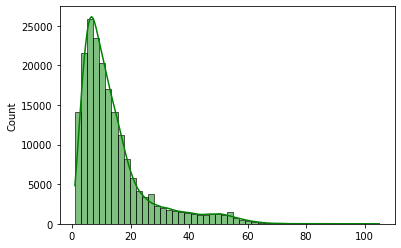

In [27]:
total_data_text = list(x) + list(x_test2)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 그래프
sns.histplot(num_tokens, kde = True, bins=50, color="g")

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

## keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [28]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(x,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen, truncating='post')

x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test2,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen, truncating='post')

print(x_train.shape)
type(x_train)

(145238, 37)


numpy.ndarray

## validation set 구성

In [29]:
x_val = x_train[:10000]   
y_val = y_train[:10000]

partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(135238, 37)
(135238,)


# 4. 모델 구성 및 학습 및 시각화

## 모델 1

### 모델 구성

In [53]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 200  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model1 = tf.keras.Sequential()
model1.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model1.add(tf.keras.layers.LSTM(128))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model1.add(tf.keras.layers.Dense(64, activation='relu'))
model1.add(tf.keras.layers.Dense(8, activation='relu'))
model1.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model1.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
lstm_6 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dense_13 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 9         
Total params: 2,177,233
Trainable params: 2,177,233
Non-trainable params: 0
_________________________________________________________________


### 모델 학습

In [54]:
model1.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=4  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history1 = model1.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=256,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/4
529/529 [==============================] - 6s 8ms/step - loss: 0.3945 - accuracy: 0.8197 - val_loss: 0.3419 - val_accuracy: 0.8481
Epoch 2/4
529/529 [==============================] - 4s 8ms/step - loss: 0.3185 - accuracy: 0.8614 - val_loss: 0.3243 - val_accuracy: 0.8573
Epoch 3/4
529/529 [==============================] - 4s 8ms/step - loss: 0.2903 - accuracy: 0.8763 - val_loss: 0.3407 - val_accuracy: 0.8562
Epoch 4/4
529/529 [==============================] - 4s 8ms/step - loss: 0.2699 - accuracy: 0.8867 - val_loss: 0.3215 - val_accuracy: 0.8617


In [55]:
results = model1.evaluate(x_test, y_test , verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3320 - accuracy: 0.8534
[0.3319966495037079, 0.8534432053565979]


### 시각화

In [56]:
history_dict = history1.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


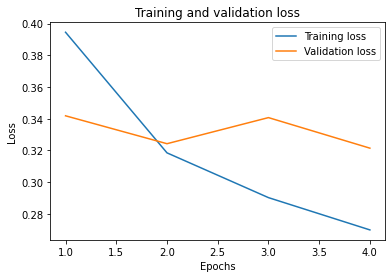

In [70]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

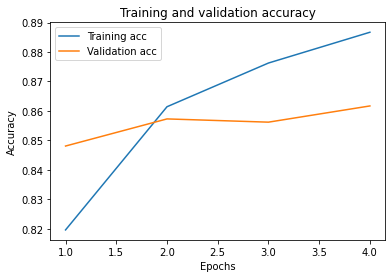

In [71]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc,label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 모델 2

### 모델 구성

In [113]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 200   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(tf.keras.layers.GlobalMaxPooling1D())
model2.add(tf.keras.layers.Dense(64, activation='relu'))
model2.add(tf.keras.layers.Dense(8, activation='relu'))
model2.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/### 모델 구성부정을 나타내는 1dim 입니다.

model2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 200)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                12864     
_________________________________________________________________
dense_15 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 9         
Total params: 2,013,393
Trainable params: 2,013,393
Non-trainable params: 0
_________________________________________________________________


### 모델 학습

In [114]:
### 모델 학습model2.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history2 = model2.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
265/265 [==============================] - 2s 5ms/step - loss: 0.4395 - accuracy: 0.8041 - val_loss: 0.3590 - val_accuracy: 0.8371
Epoch 2/5
265/265 [==============================] - 1s 4ms/step - loss: 0.3307 - accuracy: 0.8572 - val_loss: 0.3427 - val_accuracy: 0.8493
Epoch 3/5
265/265 [==============================] - 1s 4ms/step - loss: 0.3062 - accuracy: 0.8704 - val_loss: 0.3498 - val_accuracy: 0.8478
Epoch 4/5
265/265 [==============================] - 1s 4ms/step - loss: 0.2902 - accuracy: 0.8799 - val_loss: 0.3426 - val_accuracy: 0.8540
Epoch 5/5
265/265 [==============================] - 1s 4ms/step - loss: 0.2780 - accuracy: 0.8857 - val_loss: 0.3478 - val_accuracy: 0.8514


In [115]:
results = model2.evaluate(x_test, y_test , verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3578 - accuracy: 0.8454
[0.3577651083469391, 0.8453667163848877]


### 시각화

In [116]:
history_dict = history2.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


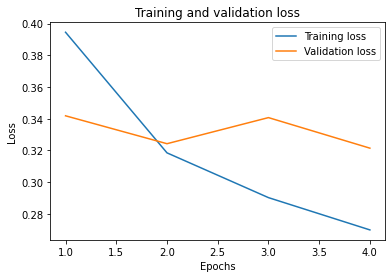

In [72]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)


plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

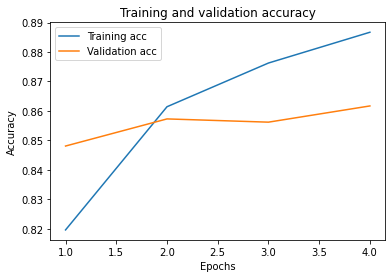

In [74]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 모델 3

### 모델 구성

In [75]:
### 모델 학습vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 100  # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model3 = tf.keras.Sequential()
model3.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model3.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model3.add(tf.keras.layers.MaxPooling1D(5))
model3.add(tf.keras.layers.GlobalMaxPooling1D())
model3.add(tf.keras.layers.Dense(8, activation='relu'))
model3.add(tf.keras.layers.Dense(1, activation='sigmoid'))
          

model3.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 100)         1000000   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 16)          11216     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 9         
Total params: 1,011,361
Trainable params: 1,011,361
Non-trainable params: 0
___________________________________________

### 모델 학습

In [76]:
### 모델 학습model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=4  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history3 = model3.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/4
265/265 [==============================] - 2s 5ms/step - loss: 0.4777 - accuracy: 0.7638 - val_loss: 0.3809 - val_accuracy: 0.8264
Epoch 2/4
265/265 [==============================] - 1s 4ms/step - loss: 0.3494 - accuracy: 0.8456 - val_loss: 0.3687 - val_accuracy: 0.8347
Epoch 3/4
265/265 [==============================] - 1s 4ms/step - loss: 0.3033 - accuracy: 0.8702 - val_loss: 0.3729 - val_accuracy: 0.8371
Epoch 4/4
265/265 [==============================] - 1s 4ms/step - loss: 0.2597 - accuracy: 0.8938 - val_loss: 0.3907 - val_accuracy: 0.8339


In [77]:
results = model3.evaluate(x_test, y_test , verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3929 - accuracy: 0.8318
[0.3929423689842224, 0.831838071346283]


### 시각화

In [78]:
### 시각화history_dict = history3.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


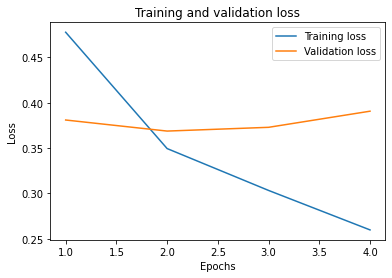

In [79]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

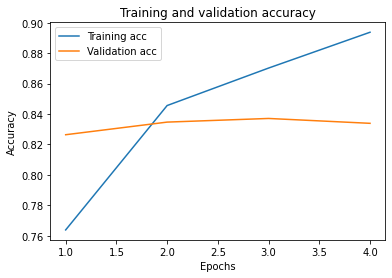

In [80]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 5. 학습된 Embedding 레이어 분석

In [160]:
# 함수화
def Embedding(model, word2vec_file_path, index_to_word, word_vector_dim):
    embedding_layer = model.layers[0]
    weights = embedding_layer.get_weights()[0]
    print(weights.shape)

    f = open(word2vec_file_path, 'w')
    f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

    # 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
    vectors = model.get_weights()[0]
    for i in range(4,vocab_size):
        f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
    f.close()

    word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
    return word_vectors

In [161]:
word2vec_file_path1 = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec1.txt'
word_vectors1 = Embedding(model1, word2vec_file_path1, index_to_word, 200)
word2vec_file_path2 = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec2.txt'
word_vectors2 = Embedding(model2, word2vec_file_path2, index_to_word, 200)
word2vec_file_path3 = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec3.txt'
word_vectors3 = Embedding(model3, word2vec_file_path3, index_to_word, 100)

(10000, 200)
(10000, 200)
(10000, 100)


In [164]:
print(word_vectors1.similar_by_word("최고"))
print(word_vectors2.similar_by_word("최고"))
print(word_vectors3.similar_by_word("최고"))

[('만점', 0.9515870809555054), ('유쾌', 0.9436687231063843), ('완벽', 0.9386677742004395), ('빠져드', 0.931903600692749), ('수작', 0.9318951368331909), ('완소', 0.9283942580223083), ('명불허전', 0.9282665848731995), ('굿', 0.9277045726776123), ('여신', 0.9253093004226685), ('웰메이드', 0.9241510033607483)]
[('굿', 0.7736398577690125), ('짱', 0.7443979382514954), ('굳', 0.7224814295768738), ('강추', 0.7157499194145203), ('괜찮', 0.7139688730239868), ('감동', 0.7087013721466064), ('명작', 0.684820830821991), ('와우', 0.6748659014701843), ('재', 0.671960175037384), ('재밌', 0.6714426279067993)]
[('단연', 0.785060465335846), ('노동자', 0.7701073884963989), ('매회', 0.7581521272659302), ('유쾌', 0.7558887600898743), ('대박', 0.7552438974380493), ('세끼', 0.7522295713424683), ('엄연히', 0.7499562501907349), ('완벽', 0.7479948997497559), ('프랭크', 0.7429924011230469), ('와우', 0.7388154864311218)]


# 6. 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [6]:
# 버전확인
print(gensim.__version__)

3.8.0


### 임베딩 가져오기

In [15]:
word2vec_path = os.getenv('HOME') +'/aiffel/aiffel_project/exploration_6/ko/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['최고']
vector.shape

/tmp/ipykernel_6246/9772395.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vector = word2vec['최고']


(200,)

In [31]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/tmp/ipykernel_6246/1730871920.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_6246/1730871920.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


### 모델 구성

In [50]:

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.LSTM(128))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 37, 200)           2000000   
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_11 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 9         
Total params: 2,177,233
Trainable params: 2,177,233
Non-trainable params: 0
_________________________________________________________________


### 모델 학습

In [51]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=4  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/4
2114/2114 [==============================] - 13s 6ms/step - loss: 0.3961 - accuracy: 0.8170 - val_loss: 0.3340 - val_accuracy: 0.8525
Epoch 2/4
2114/2114 [==============================] - 12s 6ms/step - loss: 0.3003 - accuracy: 0.8713 - val_loss: 0.3218 - val_accuracy: 0.8616
Epoch 3/4
2114/2114 [==============================] - 12s 6ms/step - loss: 0.2577 - accuracy: 0.8919 - val_loss: 0.3276 - val_accuracy: 0.8621
Epoch 4/4
2114/2114 [==============================] - 12s 6ms/step - loss: 0.2181 - accuracy: 0.9104 - val_loss: 0.3396 - val_accuracy: 0.8587


In [81]:
results = model.evaluate(x_test,  y_test, verbose=2)
print(results)   

1537/1537 - 3s - loss: 0.3404 - accuracy: 0.8523
[0.34044912457466125, 0.8522835969924927]


### 시각화

In [59]:
history_dict_word = history.history
print(history_dict_word.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


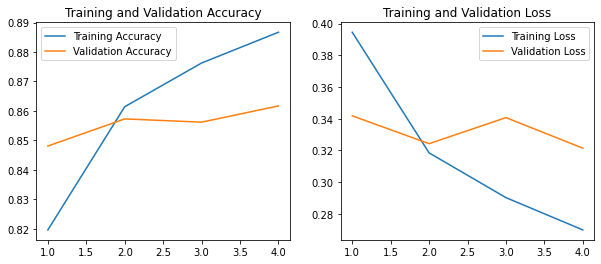

In [73]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)


# Accuracy 그래프
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# 회고

## 발생했던 오류
- 처음 모델을 만들고 학습할때 오류 발생
    - ValueError: Failed to find data adapter that can handle input: (<class 'list'> containing values of types {"<class 'numpy.ndarray'>"}), (<class 'list'> containing values of types {"<class 'numpy.int64'>"})
    - 오류 이유 : x_train에서 빈 리스트 값을 삭제하면서 y_train도 같이 삭제하였는데 그때 y_train이 리스트로 변환되어 문제가 발생
    - 해결 방안 : y_train = np.array(y_train)
<br>
<br>
<br>

- con1d 모델 만들고 학습시 오류 발생
    - 오류 내용: shape 문제가 발생
    - 오류 이유 : model3.add(tf.keras.layers.Conv1D(16, 7, activation='relu')) 작성후 model3.add(tf.keras.layers.MaxPooling1D(5)) 작성후 model3.add(tf.keras.layers.Conv1D(16, 7, activation='relu')) 했을때 3번째 레이어에서 문제 발생
    - 해결 방안 : 3번째 레이어 삭제 -> model3.add(tf.keras.layers.Conv1D(16, 7, activation='relu')) 작성후 model3.add(tf.keras.layers.MaxPooling1D(5)) 작성
    - 이 문제는 적확한 문제를 알 수 없어서 추가로 공부가 필요하다고 생각됩니다.
<br>
<br>
<br> 

- Embedding 함수화시 똑같은 결과 반화돼는 문제
    - 이유 : 아직도 잘 모르겠습니다.
    - 해결 : 다시 만드니 잘 돌아갑니다.

## 한국어 Word2Vec 임베딩 활용하여 성능 개선에 대한 생각
- 모델 1번과 비슷한 방식으로 모델 구성
- 이것을 이용하여 성능을 개선 할려고 했지만 성능 개선을 거의 못함
- 데이터셋에 다양성을 줄인것이 원인중 하나지 않을까 생각됩니다.
    - 한글도 완성된 글자가 아니면 전부 삭제 했습니다.
- 이중적인 의미가 들어간 문장으로 인해서 모델의 최대 성능에 한계가 있는 것이 아닌가 판단됩니다.

## 추가로 해보고 싶은 것

- 앙상블 기법중 배깅을 이용하여 모델 성능 개선을 시도해 보고 싶습니다.
- 데이터 전처리시 완성된 한글이 아닌 한글 전체로 해보고 싶습니다.
- conv1d나 LSTM 레이어 구성에 대해서 추가로 공부를 해보고 싶습니다.

## 모델 구성시 시도한 것
- tf.keras.layers.Dense(8, activation='relu') 레이어를 추가하여 돌려 보았습니다.
- 패딩시 pre와 post를 해보았는데 성능에 차이는 없었습니다.
- 배치 사이즈(32, 64, 128, 256, 512)를 다양하게 주어 보았습니다. 

## 모델 별 결과
- 모델 1 : loss: 0.3320 - accuracy: 0.8534
- 모델 2 : loss: 0.3578 - accuracy: 0.8454
- 모델 3 : loss: 0.3929 - accuracy: 0.8318
- 한국어 word2vec 임베딩 활용 모델 : loss: 0.3404 - accuracy: 0.8523